CampaignDiagram with kernels:
Kernel(name=EinsumA, start=0, duration=0.75, compute_util=0.7, memory_util=0.0625, compute_color=#FF0000, memory_util_limit=0.25)
Kernel(name=EinsumB, start=0.75, duration=2.5, compute_util=0.2, memory_util=0.225, compute_color=#00FF00, memory_util_limit=0.25)
Kernel(name=EinsumA, start=3.25, duration=0.75, compute_util=0.7, memory_util=0.0625, compute_color=#FF0000, memory_util_limit=0.25)
Kernel(name=EinsumB, start=4.0, duration=2.5, compute_util=0.2, memory_util=0.225, compute_color=#00FF00, memory_util_limit=0.25)
Kernel(name=EinsumA, start=6.5, duration=0.75, compute_util=0.7, memory_util=0.0625, compute_color=#FF0000, memory_util_limit=0.25)
Kernel(name=EinsumB, start=7.25, duration=2.5, compute_util=0.2, memory_util=0.225, compute_color=#00FF00, memory_util_limit=0.25)
Kernel(name=EinsumA, start=9.75, duration=0.75, compute_util=0.7, memory_util=0.0625, compute_color=#FF0000, memory_util_limit=0.25)
Kernel(name=EinsumB, start=10.5, duration=2.5, com

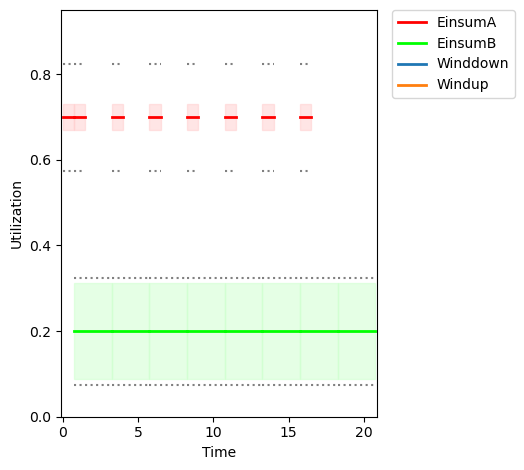

In [9]:
import copy

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors

from typing import Tuple
from typing import List

class KernelColor:
    # Define a list of 24 common colors in hexadecimal format
    colors = [
        "#FF0000",  # Red
        "#00FF00",  # Green
        "#0000FF",  # Blue
        "#FFFF00",  # Yellow
        "#FF00FF",  # Magenta
        "#00FFFF",  # Cyan
        "#C0C0C0",  # Silver
        "#808080",  # Gray
        "#800000",  # Maroon
        "#808000",  # Olive
        "#008000",  # Dark Green
        "#800080",  # Purple
        "#000080",  # Navy
        "#FFA500",  # Orange
        "#FFC0CB",  # Pink
        "#FFD700",  # Gold
        "#F08080",  # Light Coral
        "#6495ED",  # Cornflower Blue
        "#228B22",  # Forest Green
        "#DB7093",  # Pale Violet Red
        "#FF6347",  # Tomato
        "#87CEEB",  # Sky Blue
        "#FFE4C4",  # Bisque
        "#98FB98",  # Pale Green
        "#9370DB"   # Medium Purple
    ]
    
    def __init__(self):
        self.current_index = 0  # Start with the first color
        self.name2color = {}

    def getColor(self, name):

        if name in self.name2color:
            return self.name2color[name]
        else:
            color = self.nextColor()
            self.name2color[name] = color
            return color
    
    def nextColor(self) -> str:
        """Return the next color in the list and wrap around if necessary."""
        color = self.colors[self.current_index]
        self.current_index = (self.current_index + 1) % len(self.colors)
        return color
    
    @staticmethod
    def lightenColor(hex_color: str, amount: float) -> str:
        """Lighten the given hex color by the specified amount.
        
        Args:
            hex_color: A string representing the color in hex format (e.g., '#rrggbb').
            amount: A float value between 0-1 indicating the percentage to lighten the color.
        
        Returns:
            A new hex color string that is lightened.
        """
        # Convert hex to RGB
        r = int(hex_color[1:3], 16)
        g = int(hex_color[3:5], 16)
        b = int(hex_color[5:7], 16)
        
        # Lighten the color
        r = min(int(r + (255 - r) * amount), 255)
        g = min(int(g + (255 - g) * amount), 255)
        b = min(int(b + (255 - b) * amount), 255)
        
        # Convert back to hex
        return f'#{r:02X}{g:02X}{b:02X}'




# Class to hold the parameters for Kernel
class Kernel:
    def __init__(self,
                 name,
                 duration,
                 compute_util,
                 memory_util,
                 memory_util_limit=1.0):

        memory_util_scaling = 0.25
        
        self.name = name
        self.start = 0 
        self.duration = duration
        self.end = duration
        self.compute_util = compute_util
        self.memory_util = memory_util_scaling * memory_util
        self.memory_util_limit = memory_util_scaling * memory_util_limit
        self.compute_color = None
        self.memory_color = None

    def set_start(self, last_end=0):
        """Sets the start time based on the last end or defaults to 0."""

        self.start = last_end
        self.end = last_end + self.duration

        return self

    def set_color(self, color):
        """ Set the color of the kernel. """

        self.compute_color = color
        self.memory_color = KernelColor.lightenColor(color,
                                                     amount=0.8)

        return self

    def scale_duration(self, scale):
        self.duration *= scale
        
        return self

    def __str__(self):
        """Returns a human-readable string representation of the Kernel's state."""
        return (f"Kernel(name={self.name}, start={self.start}, duration={self.duration}, "
                f"compute_util={self.compute_util}, memory_util={self.memory_util}, "
                f"compute_color={self.compute_color}, memory_util_limit={self.memory_util_limit})")

class Cascade:
    """A class to manage a collection of Kernel instances."""
    
    def __init__(self, kernels: List[Kernel], offset=0):
        kernel_color = KernelColor()
        
        last_end = offset
        for kernel in kernels:
            kernel.set_start(last_end)
            last_end = kernel.end
            
        for kernel in kernels:
            name = kernel.name
            kernel.set_color(kernel_color.getColor(name))

        self.kernels = kernels
    
    def __iter__(self):
        """Return an iterator over the Kernel instances."""
        return iter(self.kernels)
    
    def __str__(self):
        """Returns a human-readable string representation of the CampaignDiagram's state."""
        kernel_states = "\n".join([str(kernel) for kernel in self.kernels])
        return f"CampaignDiagram with kernels:\n{kernel_states}"

# Class to draw the plot using a list of Kernel objects
class CampaignDiagram:
    def __init__(self, kernel_list):
        self.kernel_list = kernel_list

    def draw(self):
        fig, ax = plt.subplots()

        labels = {}
        
        for kernel in self.kernel_list:

            # Only label each kernel name once
            if kernel.name in labels:
                label = None
            else:
                label = kernel.name
                labels[kernel.name] = True
                
            # Draw the compute line with a label (name)
            ax.plot([kernel.start, kernel.end],
                    [kernel.compute_util, kernel.compute_util], 
                    color=kernel.compute_color,
                    lw=2,
                    label=label)

            # Draw the memory rectangle centered at compute_util (no label for memory)
            rect_height = kernel.memory_util
            rect_bottom = kernel.compute_util - rect_height / 2
            rect = patches.Rectangle((kernel.start, rect_bottom), kernel.duration, 
                                     rect_height, color=kernel.memory_color, alpha=0.5)
            ax.add_patch(rect)

            # Draw dotted black lines at the limits of memory_util_limit
            memory_top = kernel.compute_util + kernel.memory_util_limit / 2  # Top of the memory limit
            memory_bottom = kernel.compute_util - kernel.memory_util_limit / 2  # Bottom of the memory limit
            ax.hlines(y=memory_top, xmin=kernel.start, xmax=kernel.end, colors='grey', linestyles='dotted')
            ax.hlines(y=memory_bottom, xmin=kernel.start, xmax=kernel.end, colors='grey', linestyles='dotted')

        # Format the plot
        start_min = min([kernel.start for kernel in self.kernel_list]) - 0.1
        end_max = max([kernel.end for kernel in self.kernel_list]) + 0.1
        max_util = max([kernel.compute_util + kernel.memory_util_limit for kernel in self.kernel_list])

        ax.set_xlim(start_min, end_max)
        ax.set_ylim(0, max_util)
        ax.set_xlabel('Time')
        ax.set_ylabel('Utilization')

        # Move the legend outside the right side of the plot
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        # Adjust layout to make room for the legend
        plt.tight_layout(rect=[0, 0, 0.85, 1])

        plt.show()

        return self

    def __str__(self):
        """Returns a human-readable string representation of the CampaignDiagram's state."""
        kernel_states = "\n".join([str(kernel) for kernel in self.kernel_list])
        return f"CampaignDiagram with kernels:\n{kernel_states}"


def pipelineCascade(cascade):
    
    # Create task cascades

    windup = Kernel(name='Windup',
                    duration=0,
                    compute_util=0,
                    memory_util=0)

    winddown = Kernel(name='Winddown',
                      duration=0,
                      compute_util=0,
                      memory_util=0)

    # TODO: have Cascades support "+"

    task1 = copy.deepcopy(cascade).kernels + [winddown]
    task2 = [windup] + copy.deepcopy(cascade).kernels
    
    # Start with a default previous_end value of zero
    previous_end = 0
    
    # Iterate over both lists in tandem
    for obj1, obj2 in zip(task1, task2):
        obj1.set_start(previous_end)
        obj2.set_start(previous_end)

        previous_end = max(obj1.end, obj2.end)
        
        print(f"{obj1.start = }")
        print(f"{obj2.start = }")
        print(f"{previous_end =}")
        
    t = Cascade([])
    t.kernels = task1+task2
    return t



if __name__ == "__main__":

    # Example usage with multiple Kernel instances
    kernel1a = Kernel(name='EinsumA',
                     duration=3,
                     compute_util=0.7,
                     memory_util=0.25)

    kernel1b = Kernel(name='EinsumB',
                     duration=10,
                     compute_util=0.2,
                     memory_util=0.9)

    kernel1c = Kernel(name='EinsumC',
                     duration=2,
                     compute_util=0.6,
                     memory_util=0.4)



    # Create the plot with a list of kernel instances
    cascade1 = Cascade([kernel1a, kernel1b, kernel1c])
#    CampaignDiagram(cascade1).draw()


    # Show tiled sequence

    repeat = 4

    kernel2a = Kernel(name='EinsumA',
                     duration=3,
                     compute_util=0.7,
                     memory_util=0.25).scale_duration(1/repeat)

    kernel2b = Kernel(name='EinsumB',
                     duration=10,
                     compute_util=0.2,
                     memory_util=0.9).scale_duration(1/repeat)

    cascade2 = Cascade([copy.copy(kernel) for kernel in repeat*[kernel2a, kernel2b]])
#    CampaignDiagram(cascade2).draw()


    print(f"{cascade2}")
    pipelinedcascade = pipelineCascade(cascade2)
    print(f"{pipelinedcascade}")
    
    CampaignDiagram(pipelinedcascade).draw()

    
